**TODO**:
- [x] Decide which code to leave for the image plotting
- [x] Determine when to transform the image masks
- [x] Determine which mask image transformation code to use
- [x] Check if there's class imbalance
- [x] Build the vanilla Unet
    - [x] Figure out how to improve the crop code
    - [x] Check that there is no problem croping odd sized layer data
- [x] Investigate the issue the size of the images and the RAM 
- [ ] Determine what is the best way to adjust the targets to the Unet's output shape
- [ ] Overfit a single batch
    - [ ] Smooth the initial loss
- [ ] ¿What is a good learning rate?
- [ ] Define a training loop
- [x] Decirle a Santiago el problema con CV2
- [ ] Comment code so far
- [ ] Que puedo aprender de la parte de training del repo de la unet
de pytorch [repo](https://github.com/milesial/Pytorch-UNet)
    - [ ] Revisar como una wandb
- [ ] See how nomalizing the input images changes training
- [ ] How to initialize the weights of the colvolutions

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, center_crop
from torchvision.utils import draw_segmentation_masks, make_grid
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from PIL import Image

from webcolors import rgb_to_name

from tqdm import tqdm

%matplotlib inline

data_dir = Path("../data/")
train_dir = data_dir / "train"
test_dir = data_dir / "test"
valid_dir = data_dir / "valid"

classes = pd.read_csv(data_dir / "class_dict.csv")
annotations = pd.read_csv(data_dir / "metadata.csv")

image_ids = annotations[annotations["split"] == "train"]["image_id"].values
transformed_masks_path = data_dir / "train_masks"

plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    """Helper function to show images in the torch format"""
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(100, 100))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


# mapping from class indices to RGB
class_to_rgb = {}
for idx, row in classes.iterrows():
    class_to_rgb[row[0]] = row[1:].to_list()
class_colors = [tuple(x) for x in class_to_rgb.values()]
num_classes = len(class_colors)

# image ids
train_ids, test_ids = train_test_split(
    image_ids, train_size=0.8, shuffle=True, random_state=42
)


def preprocess_mask(mask, class_colors):
    """
    Transforms a mask from RGB format to a tensor of shape (H, W)
    where a pixel represents the class label
    """
    num_classes = len(class_colors)
    h, w = mask.shape[1:]  # shape expected to be (C, H, W)
    semantic_map = torch.zeros((h, w), dtype=torch.uint8)
    # iterate over all the classes
    for idx, color in enumerate(class_colors):
        color = torch.tensor(color).view(3, 1, 1)  # rgb value
        class_map = torch.all(torch.eq(mask, color), 0)
        semantic_map[class_map] = idx
    return semantic_map


def ohe_mask(mask, num_classes):
    """Turns a label tensor of shape(H, W) to (num_classes, H, W)"""
    return torch.permute(
        F.one_hot(mask.type(torch.long), num_classes=num_classes).type(torch.bool),
        (2, 0, 1),
    )

/home/david/miniconda3/envs/kaggle/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading

In [2]:
class LandcoverDataset(Dataset):
    def __init__(
        self, satimgs_dir, masks_dir, image_ids, transform=None, augmentations=None
    ):
        self.satimgs_dir = satimgs_dir
        self.masks_dir = masks_dir
        self.image_ids = image_ids
        self.transform = transform
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        # probably need to rescale the input values
        sat_img = read_image(str(self.satimgs_dir / f"{image_id}_sat.jpg")).float()
        mask = read_image(str(self.masks_dir / f"{image_id}_mask.png")).long()

        if self.transform is not None:
            sat_img = self.transform(sat_img)
        if self.augmentations is not None:
            mask = self.augmentations(mask)

        return sat_img, mask.squeeze()

## My implementation

In [ ]:
def double_conv(in_channels, out_channels):
    """3x3Conv -> ReLU -> 3x3Conv ->ReLU"""
    conv = nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=3, bias=True
        ),
        nn.ReLU(inplace=True),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            bias=True,
        ),
        nn.ReLU(inplace=True),
    )
    return conv


class Unet(nn.Module):
    """Vanilla unet architecture from the original paper"""

    def __init__(self):
        super().__init__()
        self.dconv1 = double_conv(in_channels=3, out_channels=64)
        self.dconv2 = double_conv(in_channels=64, out_channels=128)
        self.dconv3 = double_conv(in_channels=128, out_channels=256)
        self.dconv4 = double_conv(in_channels=256, out_channels=512)
        self.dconv5 = double_conv(in_channels=512, out_channels=1024)

        self.tconv1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512, kernel_size=(2, 2), stride=2, padding=0
        )
        self.dconv6 = double_conv(in_channels=1024, out_channels=512)
        self.tconv2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, kernel_size=(2, 2), stride=2, padding=0
        )
        self.dconv7 = double_conv(in_channels=512, out_channels=256)
        self.tconv3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, kernel_size=(2, 2), stride=2, padding=0
        )
        self.dconv8 = double_conv(in_channels=256, out_channels=128)
        self.tconv4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, kernel_size=(2, 2), stride=2, padding=0
        )
        self.dconv9 = double_conv(in_channels=128, out_channels=64)

        self.outconv = nn.Conv2d(
            in_channels=64, out_channels=num_classes, kernel_size=(1, 1), bias=True
        )

    def forward(self, x):
        # contracting path
        s1 = self.dconv1(x)
        x = F.max_pool2d(s1, kernel_size=(2, 2))
        s2 = self.dconv2(x)
        x = F.max_pool2d(s2, kernel_size=(2, 2))
        s3 = self.dconv3(x)
        x = F.max_pool2d(s3, kernel_size=(2, 2))
        s4 = self.dconv4(x)
        x = F.max_pool2d(s4, kernel_size=(2, 2))

        x = self.dconv5(x)

        # expansive path
        x = F.relu(self.tconv1(x))
        x = self.dconv6(torch.cat((x, center_crop(s4, x.shape[-1])), dim=1))
        x = F.relu(self.tconv2(x))
        x = self.dconv7(torch.cat((x, center_crop(s3, x.shape[-1])), dim=1))
        x = F.relu(self.tconv3(x))
        x = self.dconv8(torch.cat((x, center_crop(s2, x.shape[-1])), dim=1))
        x = F.relu(self.tconv4(x))
        x = self.dconv9(torch.cat((x, center_crop(s1, x.shape[-1])), dim=1))

        x = self.outconv(x)
        return x

## Analisis de las probabilidades en inicialización

In [5]:
f"Expected initial loss: {-torch.tensor(1/num_classes).log().item():.5f}"

'Expected initial loss: 1.94591'

Cómo se pudo ver en el análisis exploratorio, la clase de terreno agricola es dominante en las imágenes, por lo tanto, queremos ver qué valor tomaría la función de pérdida asumiendo que la mayoría de las veces le va a asignar una alta probabilidad a esta clase sobre las demas:

In [ ]:
props = [
    0.108034648001194,
    0.5773615837097168,
    0.08483955264091492,
    0.11161921918392181,
    0.0331253856420517,
    0.08450789749622345,
    0.0005117484251968563,
]
for idx, p in enumerate(props):
    print(
        f"loss for predicting class {idx} most of the time: {-torch.tensor(p).log().item():.5f}"
    )

loss for predicting class 0 most of the time: 2.22530
loss for predicting class 1 most of the time: 0.54929
loss for predicting class 2 most of the time: 2.46699
loss for predicting class 3 most of the time: 2.19266
loss for predicting class 4 most of the time: 3.40746
loss for predicting class 5 most of the time: 2.47091
loss for predicting class 6 most of the time: 7.57768


Podemos observar que con esta sencilla suposición el baseline y la pérdida es mucho más bajo que suponiendo que todas las clases tuvieran la misma probabilidad.

----

## Overfitting a single batch of images

Ahora estoy intentando hacer overfit en un batch de datos de 5 imagenes. Estoy usando un optimizador SGD con una taza de aprendizaje de 0.001. 

Durante el procesamiento de datos olvide escalar los valores de las imágenes de entrada a números pequeños. Con el fin de comprobar que efectivamente es necesario reescalar estos valores voy a hacer un pequeño experimento en el cual voy a intentar hacer overfitting sobre un batch de 5 imagenes. Espero ver que las imágenes que toman valores pequeños tienen mejores resultados en términos de la tasa de convergencia de la función de pérdida.

In [6]:
temp_dataset = LandcoverDataset(
    train_dir,
    transformed_masks_path,
    train_ids,
    transform=torchvision.transforms.Resize(512),
    augmentations=torchvision.transforms.Resize(324),
)
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Allocated GPU memory", torch.cuda.memory_allocated())

Allocated GPU memory 0


In [ ]:
def overfit_one_batch(X, y, iters, lr=0.001):
    torch.manual_seed(1)
    lossi = []
    model = Unet().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    X, y = X.to(device), y.to(device)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for i in range(iters):
        preds = model(X)
        loss = loss_fn(preds, y)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lossi.append(loss.detach().item())
        if i % 50 == 0:
            print(f"loss: {loss.item():>7f}  [{i:>5d}/{iters:>5d}]")

        plt.plot(lossi)

    with torch.no_grad():
        return model(X)

In [7]:
temp_dataloader = DataLoader(temp_dataset, batch_size=5)
X, y = next(iter(temp_dataloader))

Estas son las imagenes del batch:

In [ ]:
imgs = [X[i].type(torch.uint8) for i in range(5)]
show(make_grid(imgs))

Output hidden; open in https://colab.research.google.com to view.

Junto con sus respectivas segmentaciones:

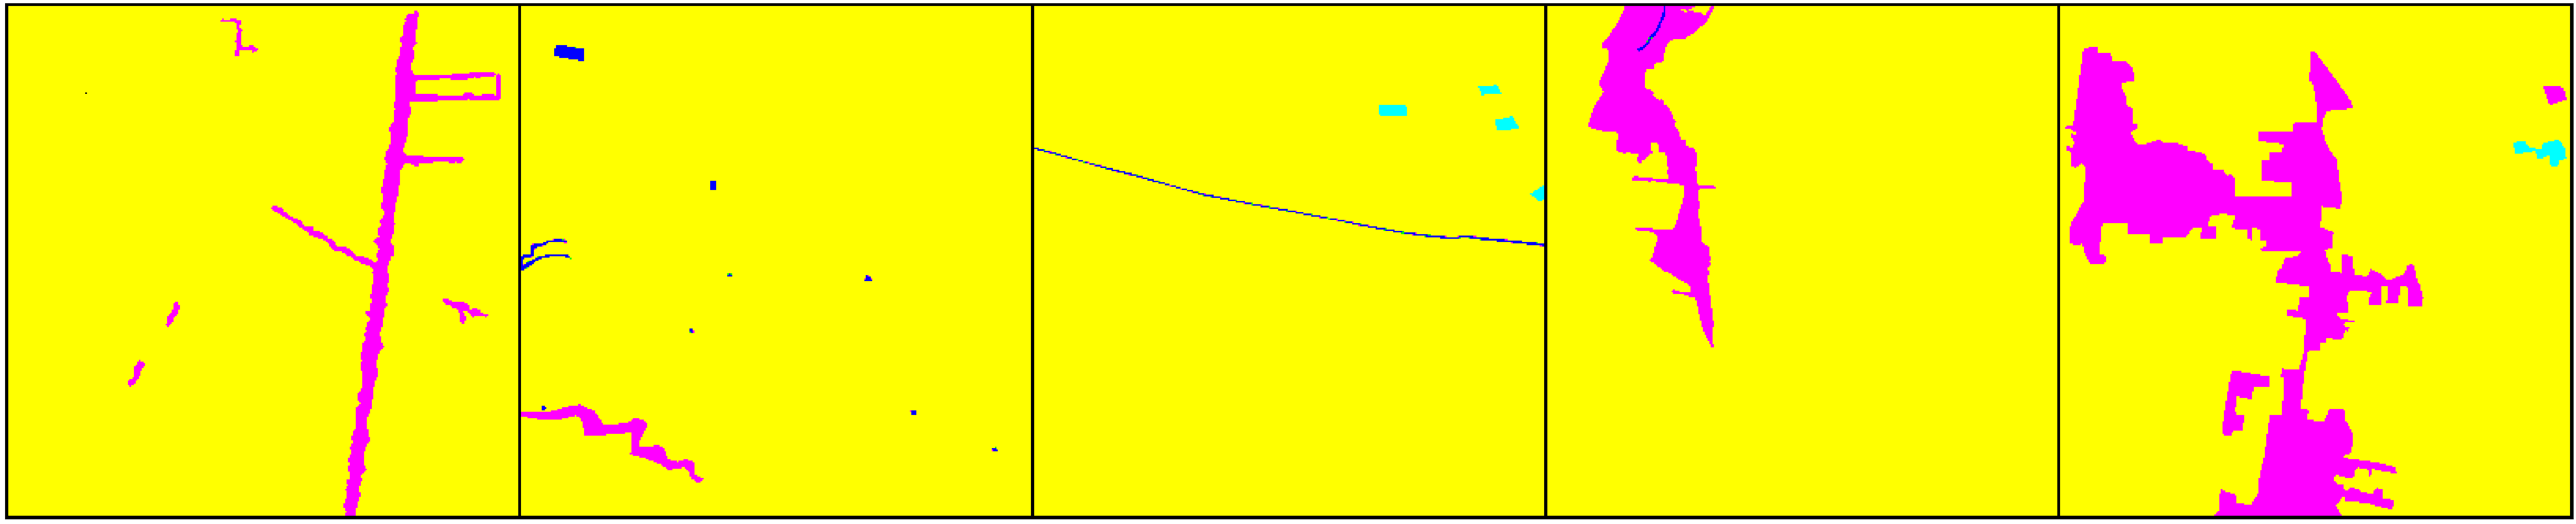

In [ ]:
masks = [y[i].type(torch.uint8) for i in range(5)]
masks = [
    draw_segmentation_masks(
        torch.zeros((3, mask.shape[-1], mask.shape[-1]), dtype=torch.uint8),
        ohe_mask(mask, num_classes),
        alpha=1,
        colors=class_colors,
    )
    for mask in masks
]
show(make_grid(masks))

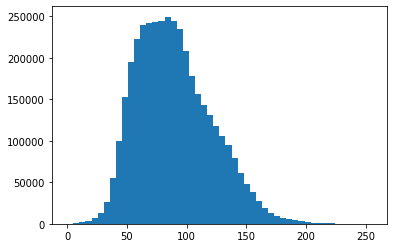

In [ ]:
# visualizamos la distribucion de los valores que toman estas imagenes
plt.hist(X.view(-1).tolist(), 50);

loss: 2.351725  [    0/ 2000]
loss: 0.248741  [   50/ 2000]
loss: 0.243633  [  100/ 2000]
loss: 0.240949  [  150/ 2000]
loss: 0.238910  [  200/ 2000]
loss: 0.237444  [  250/ 2000]
loss: 0.236128  [  300/ 2000]
loss: 0.234869  [  350/ 2000]
loss: 0.233694  [  400/ 2000]
loss: 0.232638  [  450/ 2000]
loss: 0.231645  [  500/ 2000]
loss: 0.230685  [  550/ 2000]
loss: 0.229716  [  600/ 2000]
loss: 0.228859  [  650/ 2000]
loss: 0.228045  [  700/ 2000]
loss: 0.227308  [  750/ 2000]
loss: 0.226666  [  800/ 2000]
loss: 0.226079  [  850/ 2000]
loss: 0.228013  [  900/ 2000]
loss: 0.227655  [  950/ 2000]
loss: 0.227476  [ 1000/ 2000]
loss: 0.227296  [ 1050/ 2000]
loss: 0.227086  [ 1100/ 2000]
loss: 0.226838  [ 1150/ 2000]
loss: 0.226556  [ 1200/ 2000]
loss: 0.226281  [ 1250/ 2000]
loss: 0.226024  [ 1300/ 2000]
loss: 0.225799  [ 1350/ 2000]
loss: 0.225588  [ 1400/ 2000]
loss: 0.225372  [ 1450/ 2000]
loss: 0.225163  [ 1500/ 2000]
loss: 0.224974  [ 1550/ 2000]
loss: 0.224780  [ 1600/ 2000]
loss: 0.22

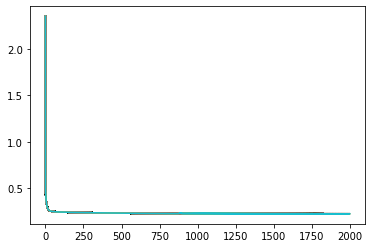

In [ ]:
%%time
# tensor without scaling
preds1 = overfit_one_batch(X, y, 2000)

In [ ]:
preds1_argmaxed = torch.argmax(preds1, 1)
preds1_argmaxed.shape

torch.Size([5, 324, 324])

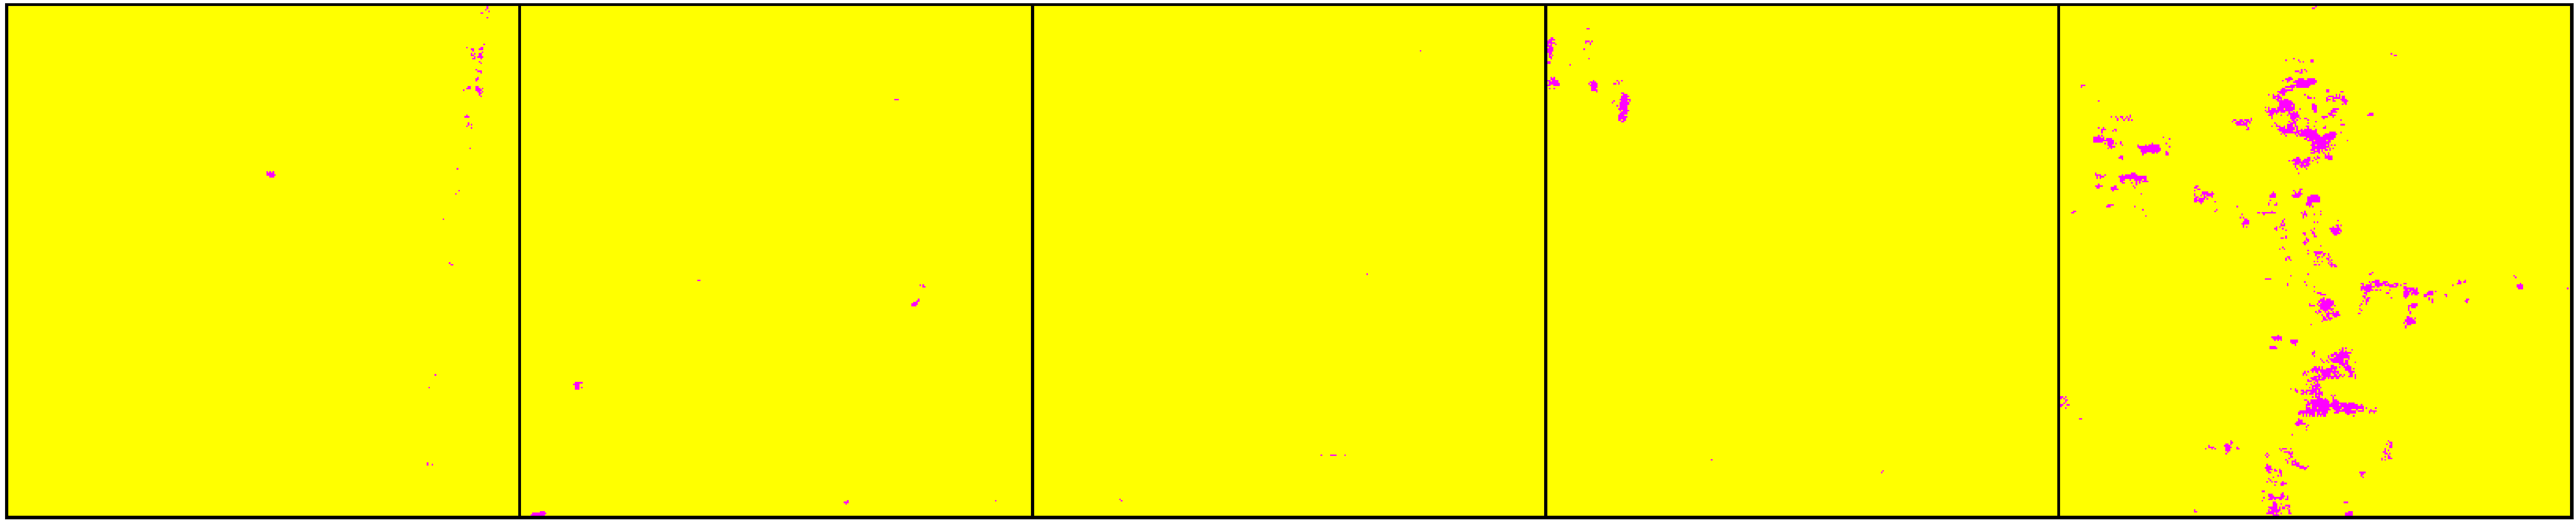

In [ ]:
masks = [preds1_argmaxed[i].type(torch.uint8) for i in range(5)]
masks = [
    draw_segmentation_masks(
        torch.zeros((3, mask.shape[-1], mask.shape[-1]), dtype=torch.uint8),
        ohe_mask(mask, num_classes),
        alpha=1,
        colors=class_colors,
    )
    for mask in preds1_argmaxed
]
show(make_grid(masks))

Ahora reescalamos los valores de las imagenes de entrada para que estén en el intervalo de 0 a 1

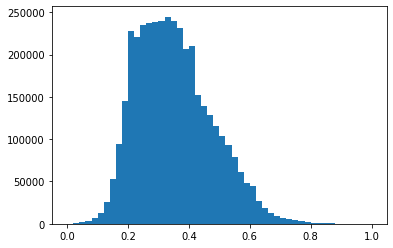

In [ ]:
plt.hist((X.view(-1) / 255.0).tolist(), 50);

loss: 2.017806  [    0/ 2000]
loss: 1.965218  [   50/ 2000]
loss: 1.914631  [  100/ 2000]
loss: 1.867703  [  150/ 2000]
loss: 1.822326  [  200/ 2000]
loss: 1.777416  [  250/ 2000]
loss: 1.732618  [  300/ 2000]
loss: 1.687021  [  350/ 2000]
loss: 1.639900  [  400/ 2000]
loss: 1.589501  [  450/ 2000]
loss: 1.530757  [  500/ 2000]
loss: 1.456804  [  550/ 2000]
loss: 1.358250  [  600/ 2000]
loss: 1.205605  [  650/ 2000]
loss: 0.954845  [  700/ 2000]
loss: 0.625011  [  750/ 2000]
loss: 0.418295  [  800/ 2000]
loss: 0.351308  [  850/ 2000]
loss: 0.329771  [  900/ 2000]
loss: 0.319725  [  950/ 2000]
loss: 0.312686  [ 1000/ 2000]
loss: 0.306597  [ 1050/ 2000]
loss: 0.301006  [ 1100/ 2000]
loss: 0.295778  [ 1150/ 2000]
loss: 0.290855  [ 1200/ 2000]
loss: 0.286204  [ 1250/ 2000]
loss: 0.281818  [ 1300/ 2000]
loss: 0.277707  [ 1350/ 2000]
loss: 0.273880  [ 1400/ 2000]
loss: 0.270343  [ 1450/ 2000]
loss: 0.267100  [ 1500/ 2000]
loss: 0.264148  [ 1550/ 2000]
loss: 0.261481  [ 1600/ 2000]
loss: 0.25

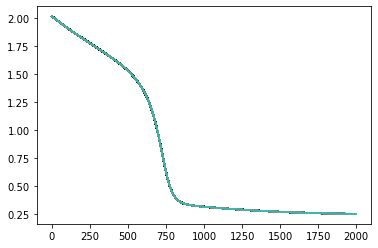

In [ ]:
%%time
preds2 = overfit_one_batch(X / 255.0, y, 2000)

In [ ]:
preds2_argmaxed = torch.argmax(preds2, 1)
preds2_argmaxed.shape

torch.Size([5, 324, 324])

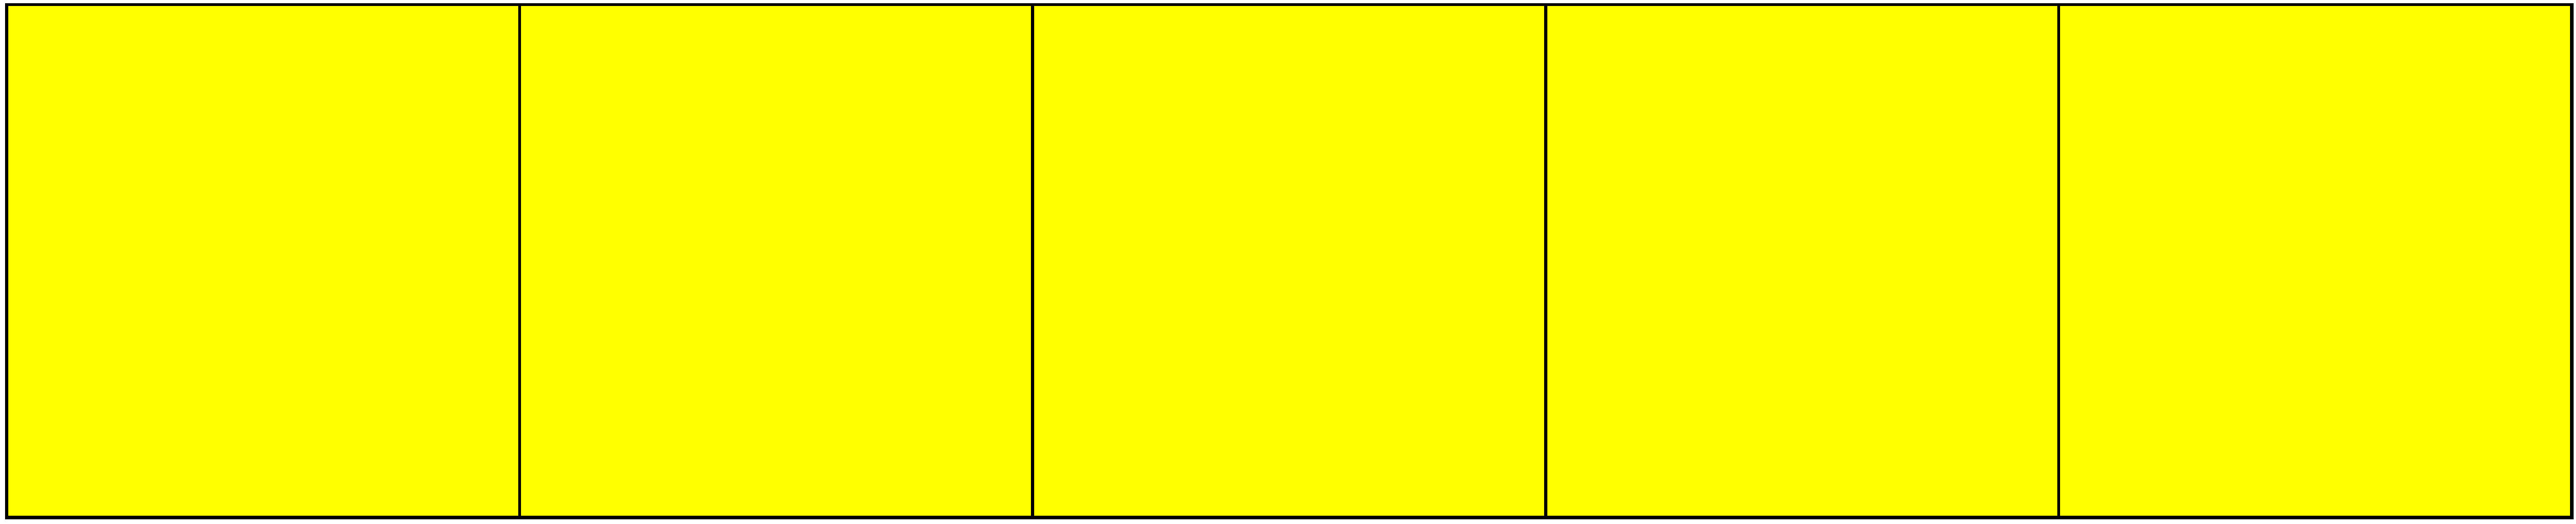

In [ ]:
masks = [preds2_argmaxed[i].type(torch.uint8) for i in range(5)]
masks = [
    draw_segmentation_masks(
        torch.zeros((3, mask.shape[-1], mask.shape[-1]), dtype=torch.uint8),
        ohe_mask(mask, num_classes),
        alpha=1,
        colors=class_colors,
    )
    for mask in preds2_argmaxed
]
show(make_grid(masks))

Ahora normalizamos para que los datos tengan una media de 0 y desviación estandar de 1.

In [ ]:
X_norm = torch.zeros(X.shape)
for c in range(3):
    mean = X[:, c].mean()
    std = X[:, c].std()
    X_norm[:, c] = (X[:, c] - mean) / std

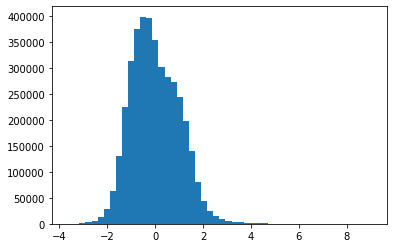

In [ ]:
plt.hist(X_norm.view(-1).tolist(), 50);

loss: 2.024401  [    0/ 2000]
loss: 1.964999  [   50/ 2000]
loss: 1.906653  [  100/ 2000]
loss: 1.847803  [  150/ 2000]
loss: 1.784416  [  200/ 2000]
loss: 1.708169  [  250/ 2000]
loss: 1.603021  [  300/ 2000]
loss: 1.429247  [  350/ 2000]
loss: 1.100481  [  400/ 2000]
loss: 0.690302  [  450/ 2000]
loss: 0.492777  [  500/ 2000]
loss: 0.433620  [  550/ 2000]
loss: 0.409692  [  600/ 2000]
loss: 0.394404  [  650/ 2000]
loss: 0.381791  [  700/ 2000]
loss: 0.370394  [  750/ 2000]
loss: 0.359818  [  800/ 2000]
loss: 0.349970  [  850/ 2000]
loss: 0.340845  [  900/ 2000]
loss: 0.332459  [  950/ 2000]
loss: 0.324824  [ 1000/ 2000]
loss: 0.317945  [ 1050/ 2000]
loss: 0.311814  [ 1100/ 2000]
loss: 0.306405  [ 1150/ 2000]
loss: 0.301674  [ 1200/ 2000]
loss: 0.297565  [ 1250/ 2000]
loss: 0.294007  [ 1300/ 2000]
loss: 0.290924  [ 1350/ 2000]
loss: 0.288239  [ 1400/ 2000]
loss: 0.285904  [ 1450/ 2000]
loss: 0.283897  [ 1500/ 2000]
loss: 0.282165  [ 1550/ 2000]
loss: 0.280647  [ 1600/ 2000]
loss: 0.27

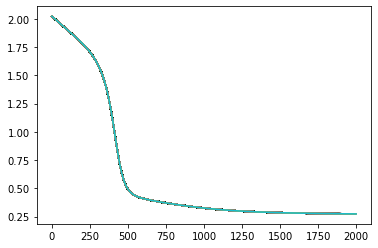

In [ ]:
%%time
preds3 = overfit_one_batch(X_norm, y, 2000)

In [ ]:
def make_predictions(preds):
    preds_argmaxed = torch.argmax(preds, 1)
    masks = [preds_argmaxed[i].type(torch.uint8) for i in range(5)]
    masks = [
        draw_segmentation_masks(
            torch.zeros((3, mask.shape[-1], mask.shape[-1]), dtype=torch.uint8),
            ohe_mask(mask, num_classes),
            alpha=1,
            colors=class_colors,
        )
        for mask in preds_argmaxed
    ]
    show(make_grid(masks))

In [ ]:
preds3_argmaxed = torch.argmax(preds3, 1)
preds3_argmaxed.shape

torch.Size([5, 324, 324])

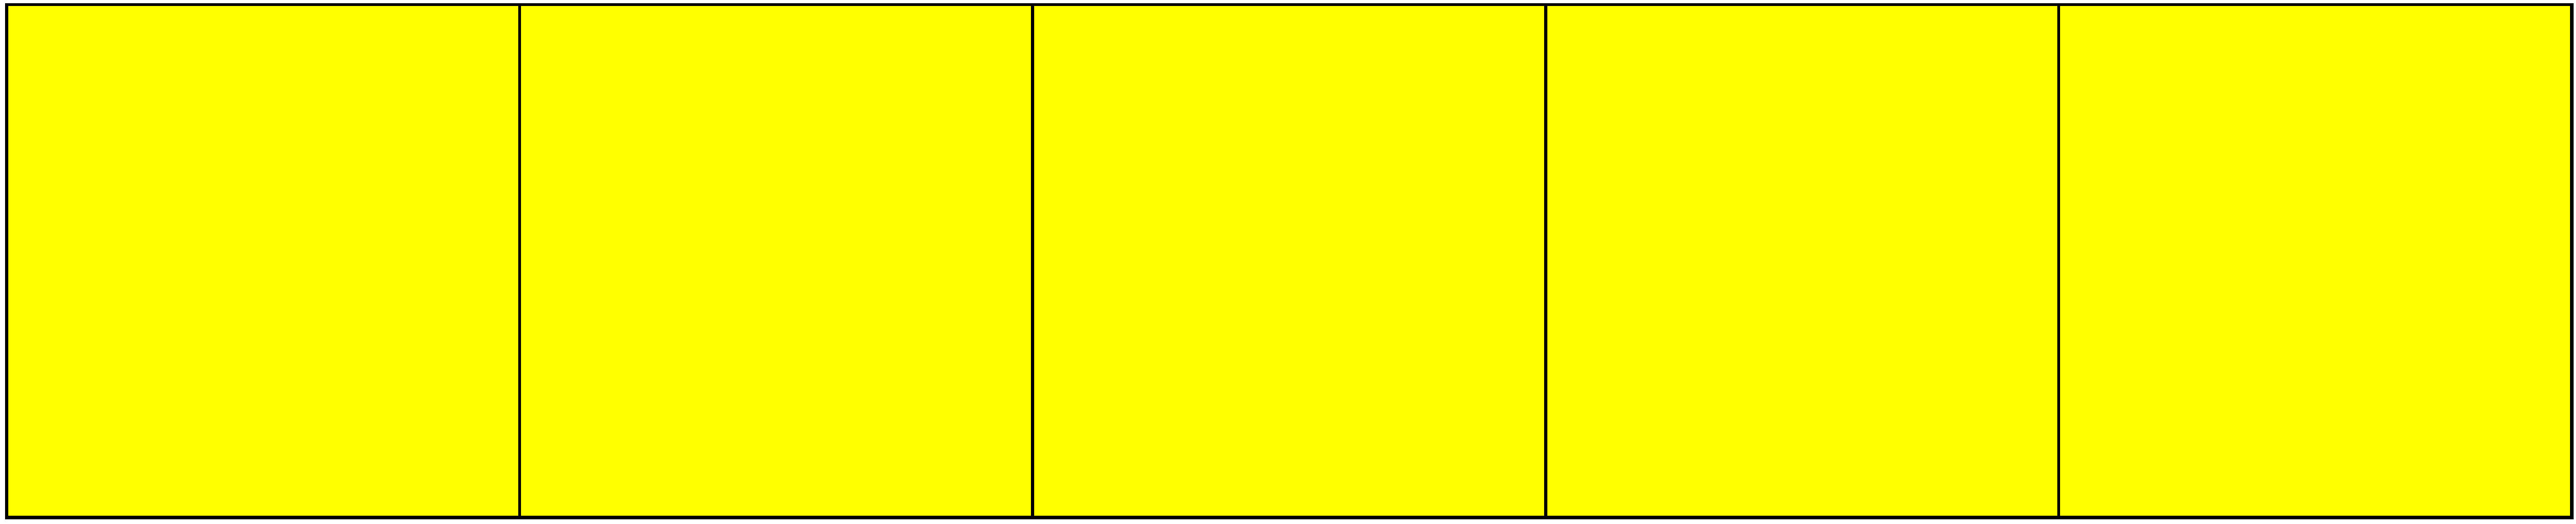

In [ ]:
masks = [preds3_argmaxed[i].type(torch.uint8) for i in range(5)]
masks = [
    draw_segmentation_masks(
        torch.zeros((3, mask.shape[-1], mask.shape[-1]), dtype=torch.uint8),
        ohe_mask(mask, num_classes),
        alpha=1,
        colors=class_colors,
    )
    for mask in preds3_argmaxed
]
show(make_grid(masks))

Puede observar que en la primera parte del entrenamiento la pérdida es bastante alta. Ante esto quiero ver cómo se comporta entrenamiento si uno calibrar las probabilidades de la capa de salida en inicialización para qué se acerquen mejor a las proporciones de las clases.

In [ ]:
def overfit_one_batch(X, y, iters, lr=0.001):
    torch.manual_seed(1)
    lossi = []
    model = Unet()
    with torch.no_grad():
        model.outconv.weight *= 0.1
        model.outconv.bias = nn.parameter.Parameter(
            torch.tensor(
                [
                    0.108034648001194,
                    0.5773615837097168,
                    0.08483955264091492,
                    0.11161921918392181,
                    0.0331253856420517,
                    0.08450789749622345,
                    0.0005117484251968563,
                ]
            )
        )

    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    X, y = X.to(device), y.to(device)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for i in range(iters):
        preds = model(X)
        loss = loss_fn(preds, y)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lossi.append(loss.detach().item())
        if i % 50 == 0:
            print(f"loss: {loss.item():>7f}  [{i:>5d}/{iters:>5d}]")

        plt.plot(lossi)

    with torch.no_grad():
        return model(X)

loss: 1.562508  [    0/ 2000]
loss: 1.531489  [   50/ 2000]
loss: 1.501124  [  100/ 2000]
loss: 1.471407  [  150/ 2000]
loss: 1.442329  [  200/ 2000]
loss: 1.413884  [  250/ 2000]
loss: 1.386063  [  300/ 2000]
loss: 1.358861  [  350/ 2000]
loss: 1.332269  [  400/ 2000]
loss: 1.306279  [  450/ 2000]
loss: 1.280885  [  500/ 2000]
loss: 1.256076  [  550/ 2000]
loss: 1.231846  [  600/ 2000]
loss: 1.208185  [  650/ 2000]
loss: 1.185082  [  700/ 2000]
loss: 1.162528  [  750/ 2000]
loss: 1.140512  [  800/ 2000]
loss: 1.119023  [  850/ 2000]
loss: 1.098047  [  900/ 2000]
loss: 1.077573  [  950/ 2000]
loss: 1.057587  [ 1000/ 2000]
loss: 1.038075  [ 1050/ 2000]
loss: 1.019023  [ 1100/ 2000]
loss: 1.000415  [ 1150/ 2000]
loss: 0.982235  [ 1200/ 2000]
loss: 0.964465  [ 1250/ 2000]
loss: 0.947087  [ 1300/ 2000]
loss: 0.930081  [ 1350/ 2000]
loss: 0.913427  [ 1400/ 2000]
loss: 0.897100  [ 1450/ 2000]
loss: 0.881072  [ 1500/ 2000]
loss: 0.865310  [ 1550/ 2000]
loss: 0.849777  [ 1600/ 2000]
loss: 0.83

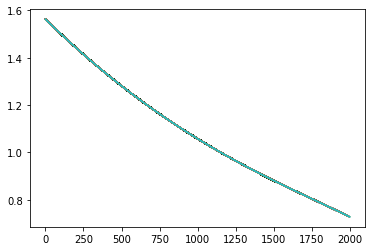

In [ ]:
%%time
preds2_cal = overfit_one_batch(X / 255.0, y, 2000)

loss: 1.563093  [    0/ 2000]
loss: 1.531806  [   50/ 2000]
loss: 1.501204  [  100/ 2000]
loss: 1.471267  [  150/ 2000]
loss: 1.441976  [  200/ 2000]
loss: 1.413314  [  250/ 2000]
loss: 1.385264  [  300/ 2000]
loss: 1.357810  [  350/ 2000]
loss: 1.330934  [  400/ 2000]
loss: 1.304616  [  450/ 2000]
loss: 1.278837  [  500/ 2000]
loss: 1.253572  [  550/ 2000]
loss: 1.228794  [  600/ 2000]
loss: 1.204473  [  650/ 2000]
loss: 1.180569  [  700/ 2000]
loss: 1.157039  [  750/ 2000]
loss: 1.133827  [  800/ 2000]
loss: 1.110862  [  850/ 2000]
loss: 1.088056  [  900/ 2000]
loss: 1.065290  [  950/ 2000]
loss: 1.042405  [ 1000/ 2000]
loss: 1.019183  [ 1050/ 2000]
loss: 0.995321  [ 1100/ 2000]
loss: 0.970385  [ 1150/ 2000]
loss: 0.943729  [ 1200/ 2000]
loss: 0.914394  [ 1250/ 2000]
loss: 0.880907  [ 1300/ 2000]
loss: 0.841030  [ 1350/ 2000]
loss: 0.791594  [ 1400/ 2000]
loss: 0.728887  [ 1450/ 2000]
loss: 0.651322  [ 1500/ 2000]
loss: 0.565218  [ 1550/ 2000]
loss: 0.486674  [ 1600/ 2000]
loss: 0.42

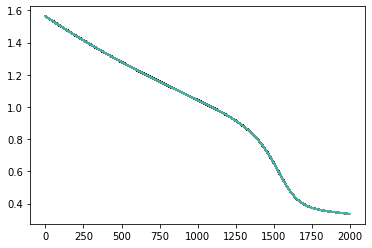

In [ ]:
%%time
preds3_cal = overfit_one_batch(X_norm, y, 2000)

Se observa que al efectuar ese cambio la pérdida empieza en un punto mucho más bajo sin embargo convergen mucho más lentamente por lo tanto voy a probar aumentar la tasa de aprendizaje 

loss: 1.562508  [    0/ 2000]
loss: 1.280648  [   50/ 2000]
loss: 1.057243  [  100/ 2000]
loss: 0.880854  [  150/ 2000]
loss: 0.728473  [  200/ 2000]
loss: 0.490946  [  250/ 2000]
loss: 0.308066  [  300/ 2000]
loss: 0.285484  [  350/ 2000]
loss: 0.267057  [  400/ 2000]
loss: 0.253993  [  450/ 2000]
loss: 0.247504  [  500/ 2000]
loss: 0.244916  [  550/ 2000]
loss: 0.243857  [  600/ 2000]
loss: 0.243370  [  650/ 2000]
loss: 0.243110  [  700/ 2000]
loss: 0.242948  [  750/ 2000]
loss: 0.242830  [  800/ 2000]
loss: 0.242734  [  850/ 2000]
loss: 0.242650  [  900/ 2000]
loss: 0.242573  [  950/ 2000]
loss: 0.242499  [ 1000/ 2000]
loss: 0.242429  [ 1050/ 2000]
loss: 0.242362  [ 1100/ 2000]
loss: 0.242297  [ 1150/ 2000]
loss: 0.242234  [ 1200/ 2000]
loss: 0.242173  [ 1250/ 2000]
loss: 0.242113  [ 1300/ 2000]
loss: 0.242055  [ 1350/ 2000]
loss: 0.241999  [ 1400/ 2000]
loss: 0.241945  [ 1450/ 2000]
loss: 0.241892  [ 1500/ 2000]
loss: 0.241840  [ 1550/ 2000]
loss: 0.241790  [ 1600/ 2000]
loss: 0.24

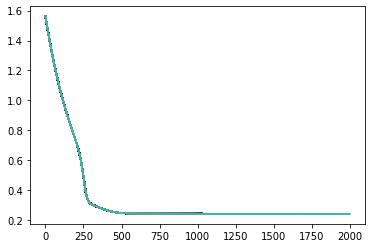

In [ ]:
%%time
preds2_cal_new_lr = overfit_one_batch(X / 255.0, y, 2000, lr=0.01)

In [ ]:
make_predictions(preds2_cal_new_lr)

In [ ]:
%%time
preds3_cal_new_lr = overfit_one_batch(X_norm, y, 2000, lr=0.01)

loss: 1.563093  [    0/ 2000]
loss: 1.278634  [   50/ 2000]
loss: 1.042686  [  100/ 2000]
loss: 0.675839  [  150/ 2000]
loss: 0.337282  [  200/ 2000]
loss: 0.294954  [  250/ 2000]
loss: 0.269548  [  300/ 2000]
loss: 0.260172  [  350/ 2000]
loss: 0.256681  [  400/ 2000]
loss: 0.254997  [  450/ 2000]
loss: 0.253968  [  500/ 2000]
loss: 0.253217  [  550/ 2000]
loss: 0.252604  [  600/ 2000]
loss: 0.252067  [  650/ 2000]
loss: 0.251578  [  700/ 2000]
loss: 0.251122  [  750/ 2000]
loss: 0.250691  [  800/ 2000]
loss: 0.250280  [  850/ 2000]
loss: 0.249887  [  900/ 2000]
loss: 0.249508  [  950/ 2000]
loss: 0.249142  [ 1000/ 2000]
loss: 0.248788  [ 1050/ 2000]
loss: 0.248445  [ 1100/ 2000]
loss: 0.248111  [ 1150/ 2000]
loss: 0.247785  [ 1200/ 2000]
loss: 0.247468  [ 1250/ 2000]
loss: 0.247157  [ 1300/ 2000]
loss: 0.246854  [ 1350/ 2000]
loss: 0.246556  [ 1400/ 2000]
loss: 0.246264  [ 1450/ 2000]
loss: 0.245977  [ 1500/ 2000]
loss: 0.245694  [ 1550/ 2000]


In [ ]:
make_predictions(preds3_cal_new_lr)

**Observaciones**:

- Después de un punto en el cual se toma a la clase dominante como la predicción dominante es difícil mejorar las predicciones y reducir la pérdida significativamente. Creo que una forma de contrarrestar este fenómeno es a través de reducir el contexto de las imágenes. Sin embargo creo que debo investigar más a fondo acerca de técnicas para tratar el imbalance de clases en imágenes. 
